In [6]:
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [7]:
import jax
import jax.numpy as jnp
import jax.lax as lax
import jax_cosmo as jc

In [8]:
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import flowpm.scipy.interpolate as interpolate

In [9]:
from jaxpm.kernels import *
from jaxpm.painting import *

In [10]:
# Below are a few parameters
box_size = [100., 100., 100.]   # Transverse comoving size of the simulation volume
nc = [100, 100, 100]            # Number of transverse voxels in the simulation volume
batch_size = 1                  # Number of simulations to run in parallel

In [11]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()

# Create some initial conditions
k = tf.constant(np.logspace(-4, 1, 128), dtype=tf.float32)
pk = linear_matter_power(cosmology, k)
pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)
initial_conditions = flowpm.linear_field(nc,
                                      box_size, 
                                      pk_fun,         
                                      batch_size=batch_size)

initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [43]:
@tf.function
def solve_tf(init_state):
    final_state = flowpm.nbody(cosmology, initial_state, linspace(0.1,1.,10), nc)
    return final_state

In [44]:
final_state = solve_tf(initial_state)

In [16]:
%timeit final_state = solve_tf(initial_state)

4.92 s ± 9.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


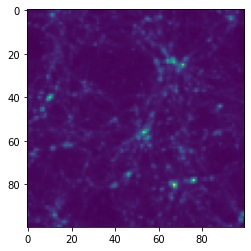

In [21]:
imshow(flowpm.cic_paint(tf.zeros([1]+nc), final_state[0]).numpy()[0].sum(axis=0))

In [12]:
mesh_shape = nc
kvec = fftk(mesh_shape)

# Define the ODE
def f(state, a, cosmo):
    # Extracts positions and velocity at a given point in
    # the simulation
    pos, vel = state
    
    # Computes the potential given the current positions
    delta_k = jnp.fft.rfftn(cic_paint(jnp.zeros(mesh_shape), pos))
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec,r_split=0)
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    forces = forces * 1.5 * cosmo.Omega_m
    
    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [13]:
from jax.experimental.ode import odeint

In [14]:
init_state = [initial_state[0,0].numpy(),
              initial_state[1,0].numpy()]

@jax.jit
def solve_ode(init_state):
    return odeint(f, init_state, 
             jnp.linspace(0.1,1.0,10), 
             jc.Planck15())

In [16]:
res = solve_ode(init_state)

In [15]:
%timeit res = solve_ode(init_state)

3.86 s ± 44.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


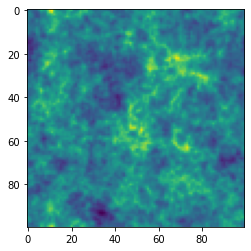

In [17]:
imshow(cic_paint(jnp.zeros(mesh_shape), initial_state[0,0].numpy()).sum(axis=0))

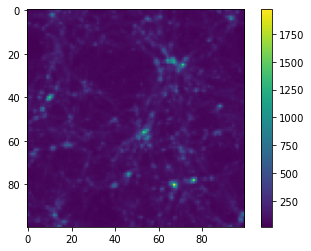

In [18]:
imshow(cic_paint(jnp.zeros(mesh_shape), res[0][-1]).sum(axis=0)); colorbar()

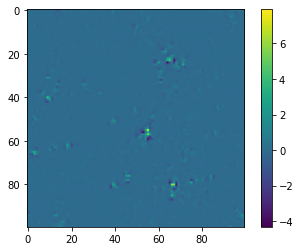

In [48]:
imshow((cic_paint(jnp.zeros(mesh_shape), res[0][-1]) - 
        flowpm.cic_paint(tf.zeros([1]+mesh_shape), final_state[0]).numpy()[0]).sum(axis=0)); colorbar()

In [5]:
from DifferentiableHOS.pk import power_spectrum

In [45]:
k, pk = power_spectrum(flowpm.cic_paint(tf.zeros([1]+mesh_shape), final_state[0]),
                       boxsize=np.array([100.,100.,100.]),                      
                       kmin=0.1,dk=2*np.pi/100.)

k, pk_jax = power_spectrum(tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), res[0][-1]).reshape([1,100,100,100])),
                       boxsize=np.array([100.,100.,100.]),                      
                       kmin=0.1,dk=2*np.pi/100.)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('Nsum', 'W', 'boxsize', 'dig', 'xsum'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('Nsum', 'W', 'boxsize', 'dig', 'xsum'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('Nsum', 'W', 'boxsize', 'dig', 'xsum'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('Nsum', 'W', 'boxsize', 'dig', 'xsum'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('Nsum', 'W', 'boxsize', 'dig', 'xsum'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('Nsum', 'W', 'boxsize', 'dig', 'xsum'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


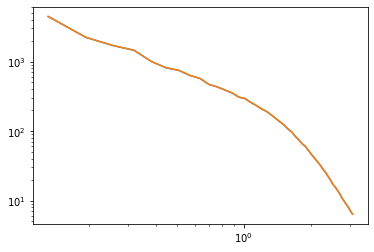

In [46]:
loglog(k,pk[0])
loglog(k,pk_jax[0])

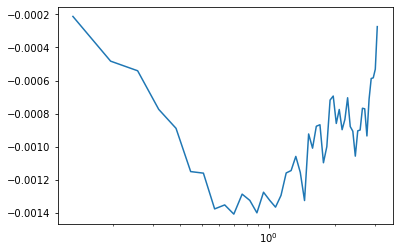

In [47]:
semilogx(k,(pk[0] - pk_jax[0])/pk[0])